# 01. Setup and Load Data

### 1.1 Dependencies Install and Setup

In [ ]:
#!pip install tensorflow==2.12.0
#!pip install tensorflow-gpu==2.12.0
#!pip install opencv-python

In [17]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam

##### This code prevents memory growth in your gpu (if you have one) meaning that it it only alow the model to use the necessary memory.

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Standardising Files Extensions

##### Seating our data folder.

In [3]:
data_dir = "data" 

In [4]:
image_exts = ["jpeg","jpg", "bmp", "png"]

##### Only run if more other file extensions are used. Parfois only uses jpg.

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print("Issue with image {}".format(image_path))
            os.remove(image_path)

# 02. Data Loading

##### This utility alow us to define our directory and separates the images by classes. We have 2 folder, with human features and with no human features.

In [2]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 831 files belonging to 2 classes.


##### The iterator alow us to get baths of images one at a time. By adding .next() we get the next batch of images.

In [3]:
data_iterator = data.as_numpy_iterator()

2024-02-03 12:33:15.723138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [831]
	 [[{{node Placeholder/_4}}]]
2024-02-03 12:33:15.723724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [831]
	 [[{{node Placeholder/_4}}]]


In [7]:
batch = data_iterator.next() #click again for new batch

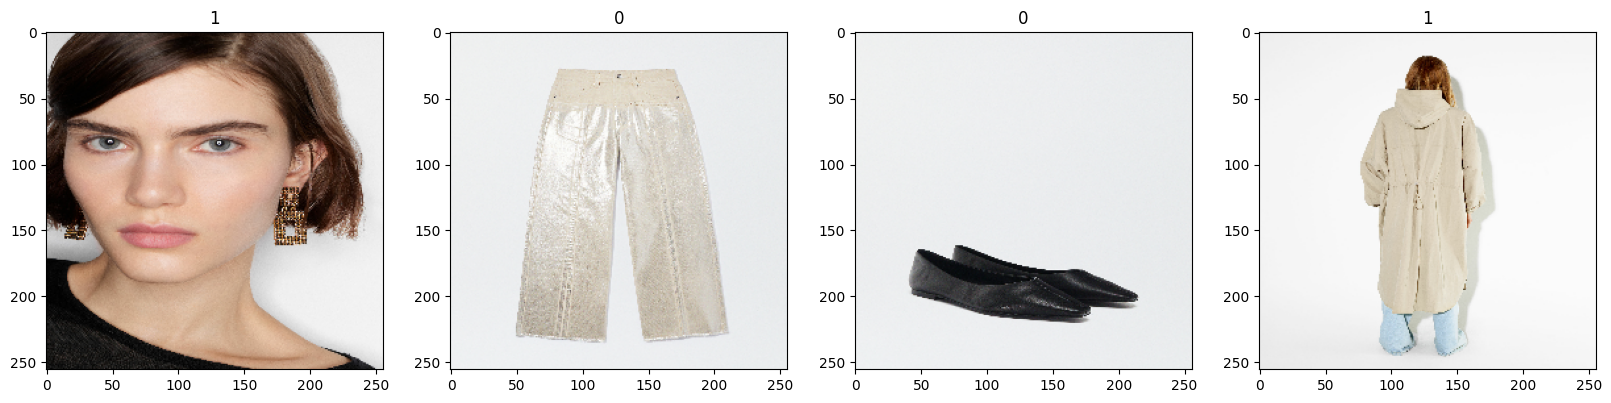

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##### We can see that the class 1 is for human features and the class zero is for no human features.

# 03. Data Scaling

In [9]:
data = data.map(lambda x, y: (x/255, y))

##### I scaled the data to have values between 0 and 1 for better performance of the model.

In [10]:
data.as_numpy_iterator().next()[0].min()

2024-02-03 12:34:59.647171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [831]
	 [[{{node Placeholder/_0}}]]
2024-02-03 12:34:59.647886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [831]
	 [[{{node Placeholder/_4}}]]


0.0

In [11]:
data.as_numpy_iterator().next()[0].max()

1.0

In [12]:
data.as_numpy_iterator().next()

(array([[[[0.8730696 , 0.8730696 , 0.8809127 ],
          [0.8808815 , 0.8808815 , 0.8887246 ],
          [0.8785296 , 0.8785296 , 0.88637275],
          ...,
          [0.79012215, 0.6450241 , 0.57306486],
          [0.7909205 , 0.6379793 , 0.57131267],
          [0.78327996, 0.6421035 , 0.555829  ]],
 
         [[0.8901961 , 0.8901961 , 0.8980392 ],
          [0.8862362 , 0.8862362 , 0.8940793 ],
          [0.8860871 , 0.8860871 , 0.89393026],
          ...,
          [0.8032101 , 0.6737983 , 0.60713166],
          [0.80385023, 0.68905246, 0.61846423],
          [0.76769215, 0.60351723, 0.5405952 ]],
 
         [[0.8862745 , 0.8862745 , 0.89411765],
          [0.8788792 , 0.8788792 , 0.8867223 ],
          [0.8900515 , 0.8900515 , 0.8978946 ],
          ...,
          [0.80252177, 0.6770316 , 0.61820805],
          [0.7803962 , 0.66673917, 0.5961167 ],
          [0.82475984, 0.71366155, 0.66401386]],
 
         ...,
 
         [[0.12899816, 0.10546875, 0.05056679],
          [0.12145

##### Every batch has the images info and an array for the class of every image in the batch.

# 04. Data Split

In [13]:
len(data)

26

In [14]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

In [15]:
test_size

2

##### Of the 26 batches of 32 images, we always need at least 1 for the test.

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 05. Model Building

##### 1. About the Cov2d layers - This layers scan the images for patterns. The first scans for basic patterns. The second uses the info of the first and scans for more complex ones and the third refines the detected patterns. 

##### 2. About the MaxPooling layers - This layers reduces the size of the detected patterns by the Cov2d, keeping only the important info. Helps speep up computation. 

##### 3. About the Flatten layer - Converts the patterns in to a list of numbers. 

##### 4. About the Dense layers - This layers are the prediction makers. The first one looks for complex patterns and seconde one decides between 0 and 1 classes.

##### 5. About the Compiler stage - Adam is a learning algorithm that adjusts the model based on its errors and the accuracy its the way we evaluate the performance.

In [31]:
parfois_model_1 = Sequential()

parfois_model_1.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
parfois_model_1.add(MaxPooling2D())

parfois_model_1.add(Conv2D(32, (3,3), 1, activation="relu"))
parfois_model_1.add(MaxPooling2D())

parfois_model_1.add(Conv2D(16, (3,3), 1, activation="relu"))
parfois_model_1.add(MaxPooling2D())

parfois_model_1.add(Flatten())

parfois_model_1.add(Dense(256, activation="relu"))
parfois_model_1.add(Dense(1, activation="sigmoid")) 

parfois_model_1.compile("adam", 
                        loss=tf.losses.BinaryCrossentropy(), 
                        metrics=["accuracy"])

In [32]:
parfois_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

# 06. Model Training

In [33]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

##### Log setting up to get the info on the performance later. 

In [36]:
hist_1 = parfois_model_1.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
18/18 [==============================] - 35s 2s/step - loss: 0.1229 - accuracy: 0.9618 - val_loss: 0.1483 - val_accuracy: 0.9438
Epoch 2/30
18/18 [==============================] - 34s 2s/step - loss: 0.0764 - accuracy: 0.9809 - val_loss: 0.0480 - val_accuracy: 0.9875
Epoch 3/30
18/18 [==============================] - 35s 2s/step - loss: 0.0263 - accuracy: 0.9896 - val_loss: 0.0324 - val_accuracy: 0.9937
Epoch 4/30
18/18 [==============================] - 34s 2s/step - loss: 0.0094 - accuracy: 0.9965 - val_loss: 0.0390 - val_accuracy: 0.9875
Epoch 5/30
18/18 [==============================] - 34s 2s/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0552 - val_accuracy: 0.9875
Epoch 6/30
18/18 [==============================] - 34s 2s/step - loss: 0.0369 - accuracy: 0.9844 - val_loss: 0.0224 - val_accuracy: 0.9812
Epoch 7/30
18/18 [==============================] - 35s 2s/step - loss: 0.0143 - accuracy: 0.9965 - val_loss: 0.0596 - val_accuracy: 0.9812
Epoch 8/30
18/18 [==

## 6.1 Model Training Results

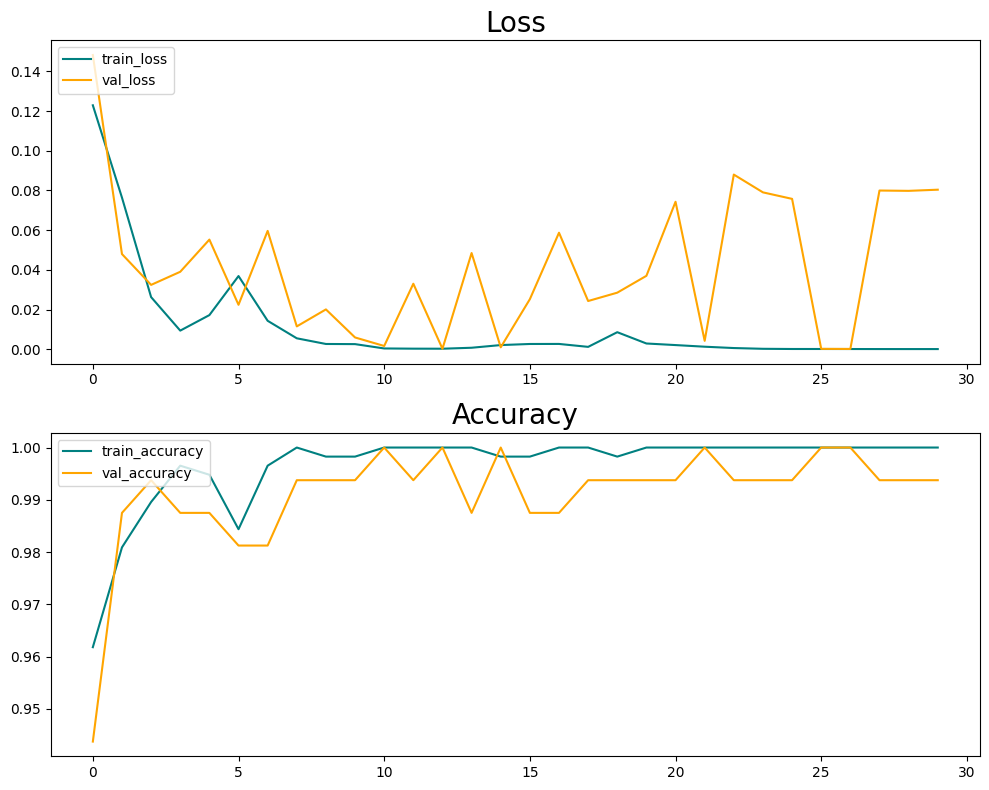

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(hist_1.history["loss"], color="teal", label="train_loss")
ax1.plot(hist_1.history["val_loss"], color="orange", label="val_loss")
ax1.set_title("Loss", fontsize=20)
ax1.legend(loc="upper left")

ax2.plot(hist_1.history["accuracy"], color="teal", label="train_accuracy")
ax2.plot(hist_1.history["val_accuracy"], color="orange", label="val_accuracy")
ax2.set_title("Accuracy", fontsize=20)
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

##### As we progress on the epocs, we should see our results stabilizing towards 0 (for loss) and 1 (for accuracy). This are the best results i could get from this kind of architecture.

# 07. Model Performance Evaluation

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
len(test)

2

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = parfois_model_1.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)    
    acc.update_state(y, yhat)
    
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

2024-02-03 13:50:14.085549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [831]
	 [[{{node Placeholder/_4}}]]
2024-02-03 13:50:14.085979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [831]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 261ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


##### Set up the threshold, meaning that output bellow 0.5 will be class 0 and above, class 1.

In [41]:
threshold = 0.5
model_predictions = (yhat > threshold).astype(int)

In [42]:
cm = confusion_matrix(y, model_predictions)
print(cm)

[[15  0]
 [ 0 17]]


##### Confusion Matrix for a better view on our model performance for both classes.

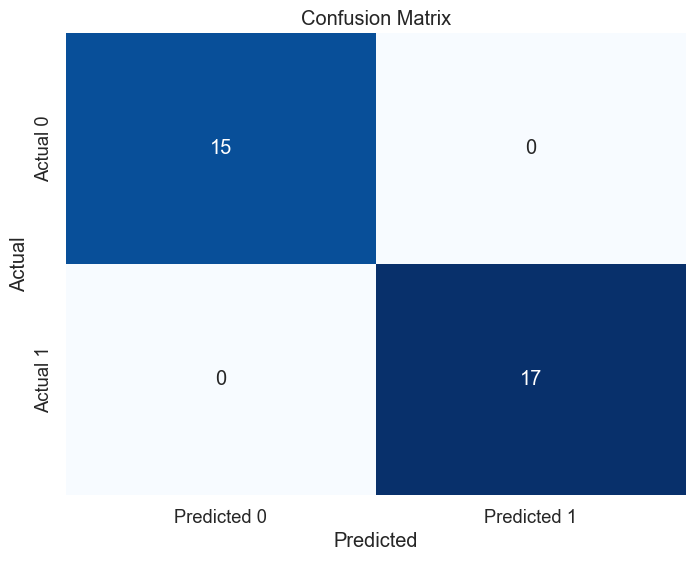

In [43]:
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 08. Model Test

##### Random image from Parfois Website that the model never saw.

<function matplotlib.pyplot.show(close=None, block=None)>

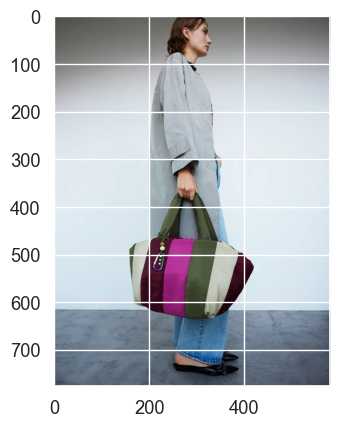

In [44]:
img = cv2.imread("human_test.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

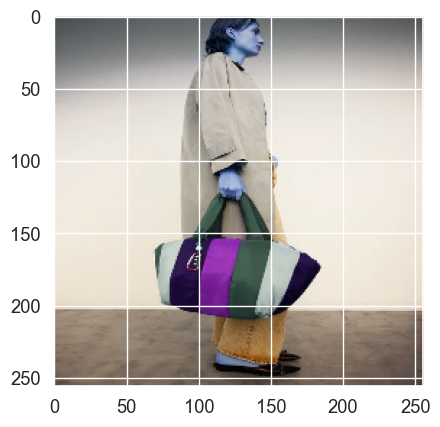

In [45]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
yhat = parfois_model_1.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 121ms/step


In [47]:
yhat

array([[0.9999981]], dtype=float32)

In [48]:
if yhat > 0.5:
    print("Predicted Class is: With Model")
else:
    print("Predicted Class is: With no Model")

Predicted Class is: With Model


<function matplotlib.pyplot.show(close=None, block=None)>

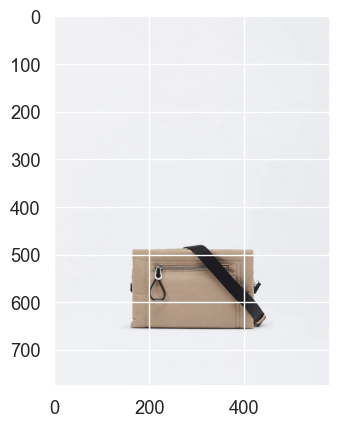

In [49]:
img2 = cv2.imread("no_human_test.jpg")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show

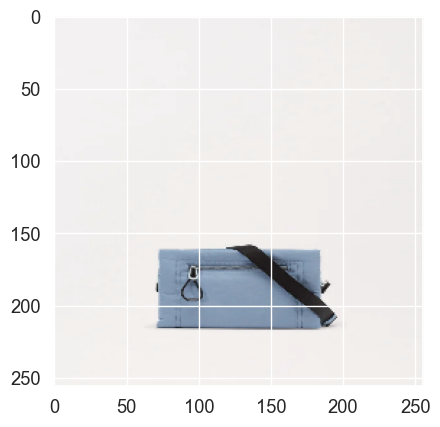

In [50]:
resize2 = tf.image.resize(img2, (256, 256))
plt.imshow(resize2.numpy().astype(int))
plt.show()

In [51]:
yhat2 = parfois_model_1.predict(np.expand_dims(resize2/255, 0))

1/1 [==============================] - 0s 40ms/step


In [52]:
yhat2

array([[3.8703045e-05]], dtype=float32)

In [53]:
if yhat2 > 0.5:
    print("Predicted Class is: With Model")
else:
    print("Predicted Class is: With no Model")

Predicted Class is: With no Model


# 09. Model Save

In [54]:
parfois_model_1.save(os.path.join('model','parfois_product_feature_classification.h5'))

# 10. Model Load

In [55]:
parfois_model_v1 = load_model(os.path.join("model", "parfois_product_feature_classification.h5"))